In [10]:
import CMGDB

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import itertools
import time
import math
import csv

In [6]:
# Methods to compute the map F

# Returns corner points of a rectangle
def CornerPoints(rect):
    dim = int(len(rect) / 2)
    # Get list of intervals
    list_intvals = [[rect[d], rect[d + dim]] for d in range(dim)]
    # Get points in the cartesian product of intervals
    X = [list(u) for u in itertools.product(*list_intvals)]
    return X

# Returns center point of a rectangle
def CenterPoint(rect):
    dim = int(len(rect) / 2)
    x_center = [(rect[d] + rect[dim + d]) / 2 for d in range(dim)]
    return [x_center]

# Return sample points in rectangle
def SamplePoints(lower_bounds, upper_bounds, num_pts):
    # Sample num_pts in dimension dim, where each
    # component of the sampled points are in the
    # ranges given by lower_bounds and upper_bounds
    dim = len(lower_bounds)
    X = np.random.uniform(lower_bounds, upper_bounds, size=(num_pts,dim))
    return list(X)

# Map that takes a rectangle and returns a rectangle
def BoxMap(f, rect, mode='corners', padding=False, num_pts=10):
    dim = int(len(rect) / 2)
    if mode == 'corners': # Compute at corner points
        X = CornerPoints(rect)
    elif mode == 'center': # Compute at center point
        padding = True # Must be true for this case
        X = CenterPoint(rect)
    elif mode == 'random': # Compute at random point
        # Get lower and upper bounds
        lower_bounds = rect[:dim]
        upper_nounds = rect[dim:]
        X = SamplePoints(lower_bounds, upper_bounds, num_pts)
    else: # Unknown mode
        return []
    # Evaluate f at point in X
    Y = [f(x) for x in X]
    # Get lower and upper bounds of Y
    Y_l_bounds = [min([y[d] for y in Y]) - ((rect[d + dim] - rect[d]) if padding else 0) for d in range(dim)]
    Y_u_bounds = [max([y[d] for y in Y]) + ((rect[d + dim] - rect[d]) if padding else 0) for d in range(dim)]
    f_rect = Y_l_bounds + Y_u_bounds
    return f_rect

In [2]:
# Define a Gaussian process
def GP(X_train, Y_train):
    # fit Gaussian Process with dataset X_train, Y_train
    kernel = RBF(0.5, (0.01, 2)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, Y_train)
    return gp

In [3]:
# Load data from file
data = np.loadtxt('PO_50.dat')
# data = np.loadtxt('PO_100.dat')

# Get X and Y vectors
X = data[:, [0,1]]
Y = data[:, [2,3]]

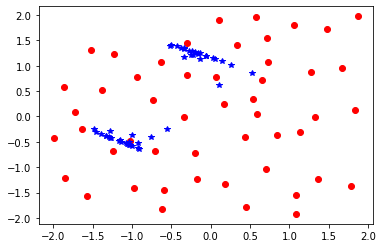

In [4]:
# Plot data
plt.plot(X[:,0], X[:,1], 'ro', Y[:,0], Y[:,1], 'b*');

In [5]:
# Train a GP with the data above
gp = GP(X, Y)

In [7]:
# Use the GP to define a map f
# Notice that the GP takes lists as
# input and output, so we need to
# add the [] below
def f(X):
    return gp.predict([X])[0]

# Define box map for f
def F(rect):
    return BoxMap(f, rect, padding=True)

Now we can use the map F above to compute the Morse graph

In [8]:
# Define the parameters for CMGDB
lower_bounds = [-2.0, -2.0]
upper_bounds = [2.0, 2.0]

subdiv_min = 20
subdiv_max = 30

morse_fname = 'morse_sets.csv'

In [11]:
%%time
morse_graph = CMGDB.MorseGraphMap(subdiv_min, subdiv_max, lower_bounds,
                                  upper_bounds, morse_fname, F)

CPU times: user 4.29 s, sys: 60 ms, total: 4.35 s
Wall time: 4.38 s


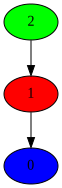

In [12]:
# Plot Morse graph
CMGDB.PlotMorseGraph(morse_graph)

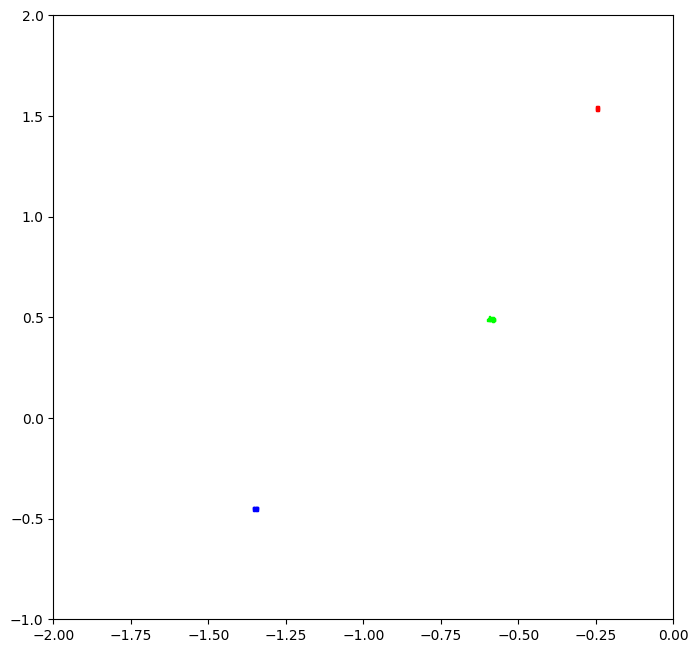

In [17]:
# Plot Morse sets
CMGDB.PlotMorseSets(morse_fname, xlim=[-2, 0], ylim=[-1, 2])